In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] "drowsiness-dataset"

In [2]:
library(tensorflow)
library(keras)

In [3]:
tf$random$set_seed(42)

In [4]:
# check TF version
tf_version()

[1] ‘2.3’

In [5]:
is_keras_available()

[1] TRUE

In [6]:
train_image_files_path <- "../input/drowsiness-dataset/train/"

In [7]:
eye_list<-c('Closed','Open','no_yawn','yawn')

In [8]:
# number of output classes (i.e. fruits)
output_n <- length(eye_list)
print(output_n)
# image size to scale down to (original images are 100 x 100 px)
img_width <- 145
img_height <- 145
target_size <- c(img_width, img_height)

# RGB = 3 channels
channels <- 3

# define batch size
batch_size <- 64

[1] 4


In [9]:
train_data_gen = image_data_generator(
  rescale = 1/255,
  validation_split = 0.1,
  horizontal_flip = TRUE,
  rotation_range = 180,
)

In [10]:
test_data_gen = image_data_generator(
  rescale = 1/255,
)

In [11]:
# training images
train_image_array_gen <- flow_images_from_directory(train_image_files_path, 
                                          train_data_gen,
                                          subset = 'training',
                                          target_size = target_size,
                                          class_mode = "categorical",
                                          classes = eye_list,
                                          batch_size = batch_size,
                                          seed = 42)

In [12]:
valid_image_array_gen <- flow_images_from_directory(train_image_files_path, 
                                          train_data_gen,
                                          subset = 'validation',
                                          target_size = target_size,
                                          class_mode = "categorical",
                                          classes = eye_list,
                                          batch_size = batch_size,
                                          seed = 42)

In [13]:
cat("Number of images per class:")
table(factor(train_image_array_gen$classes))

Number of images per class:


  0   1   2   3 
654 654 653 651 

In [14]:
train_image_array_gen_t <- train_image_array_gen$class_indices %>%
  as_tibble()
train_image_array_gen_t

Closed,Open,no_yawn,yawn
<int>,<int>,<int>,<int>
0,1,2,3


In [15]:
# number of training samples
train_samples <- train_image_array_gen$n
print(train_samples)
# number of validation samples
valid_samples <- valid_image_array_gen$n
print(valid_samples)
# define number of epochs
epochs <- 100

[1] 2612
[1] 288


In [16]:
model <- keras_model_sequential()

# add layers
model %>%
  layer_conv_2d(filter = 256, kernel_size = c(3,3), input_shape = c(img_width, img_height, channels)) %>%
  layer_activation("relu") %>%
  layer_max_pooling_2d(pool_size = c(2,2)) %>%
 
  
  # Second hidden layer
  layer_conv_2d(filter = 128, kernel_size = c(3,3)) %>%
  layer_activation("relu") %>%
  layer_max_pooling_2d(pool_size = c(2,2)) %>%
  
  
  # Third hidden layer
  layer_conv_2d(filter = 64, kernel_size = c(3,3)) %>%
  layer_activation("relu") %>%
  layer_max_pooling_2d(pool_size = c(2,2)) %>%

  # Fourth hidden layer
  layer_conv_2d(filter = 32, kernel_size = c(3,3)) %>%
  layer_activation("relu") %>%
  layer_max_pooling_2d(pool_size = c(2,2)) %>%
 
  # Flatten max filtered output into feature vector 
  # and feed into dense layer
  layer_flatten() %>%
  layer_dropout(0.5) %>%
  layer_dense(64) %>%
  layer_activation("relu") %>%
  

  # Outputs from dense layer are projected onto output layer
  layer_dense(output_n) %>% 
  layer_activation("softmax")

# compile
model %>% compile(
  loss = "categorical_crossentropy",
  optimizer = "adam",
  metrics = "accuracy"
)

In [17]:
summary(model)

Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_3 (Conv2D)                   (None, 143, 143, 256)           7168        
________________________________________________________________________________
activation_5 (Activation)           (None, 143, 143, 256)           0           
________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)      (None, 71, 71, 256)             0           
________________________________________________________________________________
conv2d_2 (Conv2D)                   (None, 69, 69, 128)             295040      
________________________________________________________________________________
activation_4 (Activation)           (None, 69, 69, 128)             0           
________________________________________________________________________________
max_pool

In [18]:
hist <- model %>% fit_generator(
# training data
train_image_array_gen,

# epochs
steps_per_epoch = as.integer(train_samples / batch_size), 
epochs = epochs, 
verbose = 1,

# validation data
validation_data = valid_image_array_gen,
validation_steps = as.integer(valid_samples / batch_size)
)
print(hist)


Final epoch (plot to see history):
        loss: 0.05322
    accuracy: 0.9819
    val_loss: 0.1643
val_accuracy: 0.9492 


`geom_smooth()` using formula 'y ~ x'



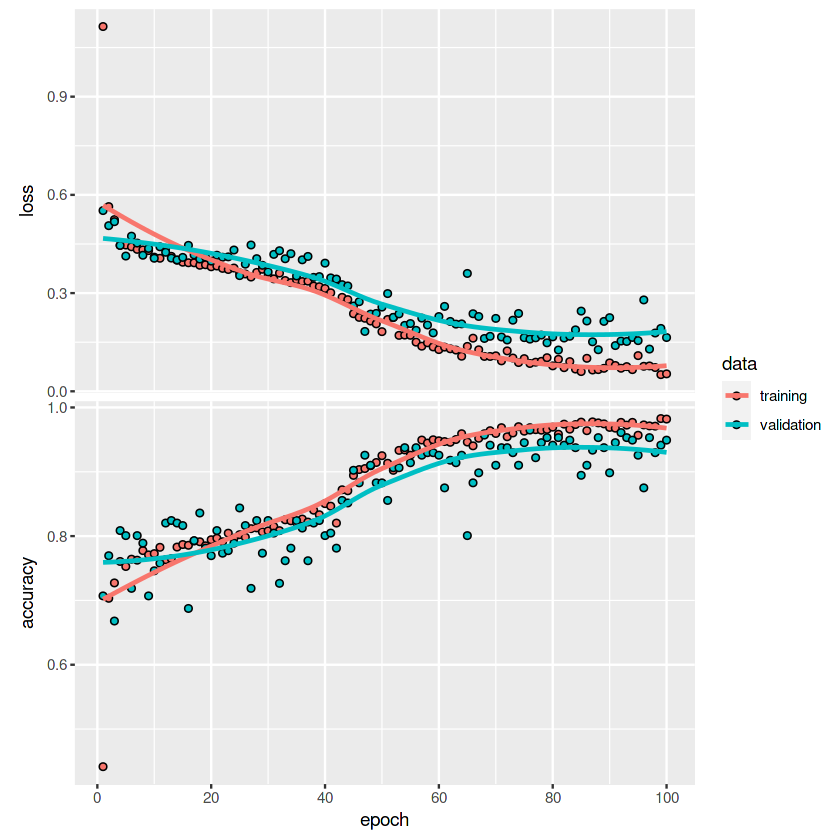

In [19]:
plot(hist)

`geom_smooth()` using formula 'y ~ x'



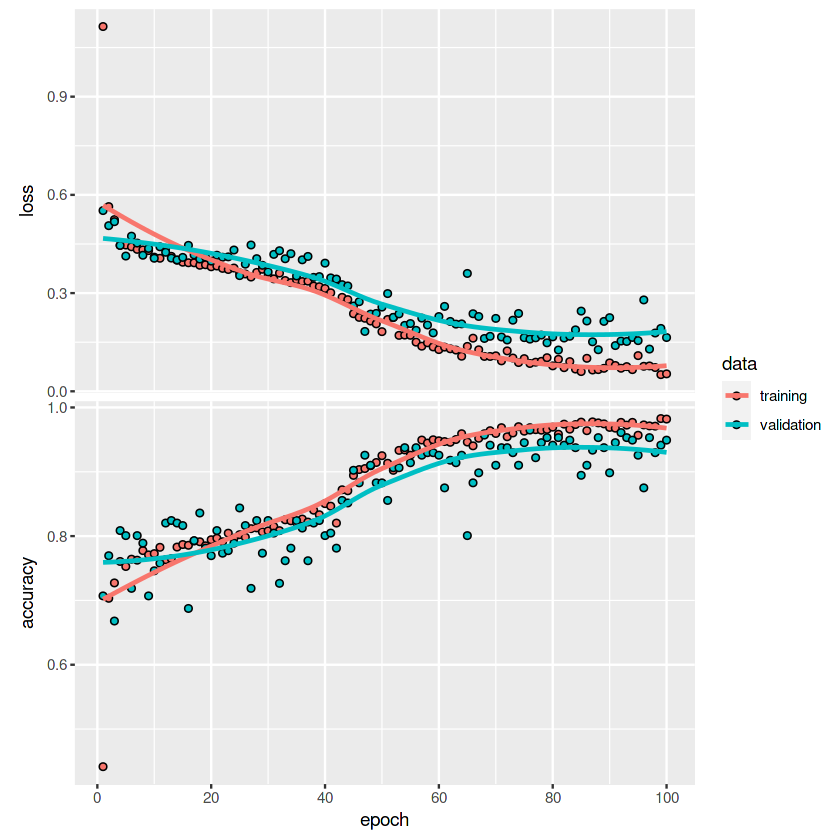

In [20]:
plot(hist)

`geom_smooth()` using formula 'y ~ x'



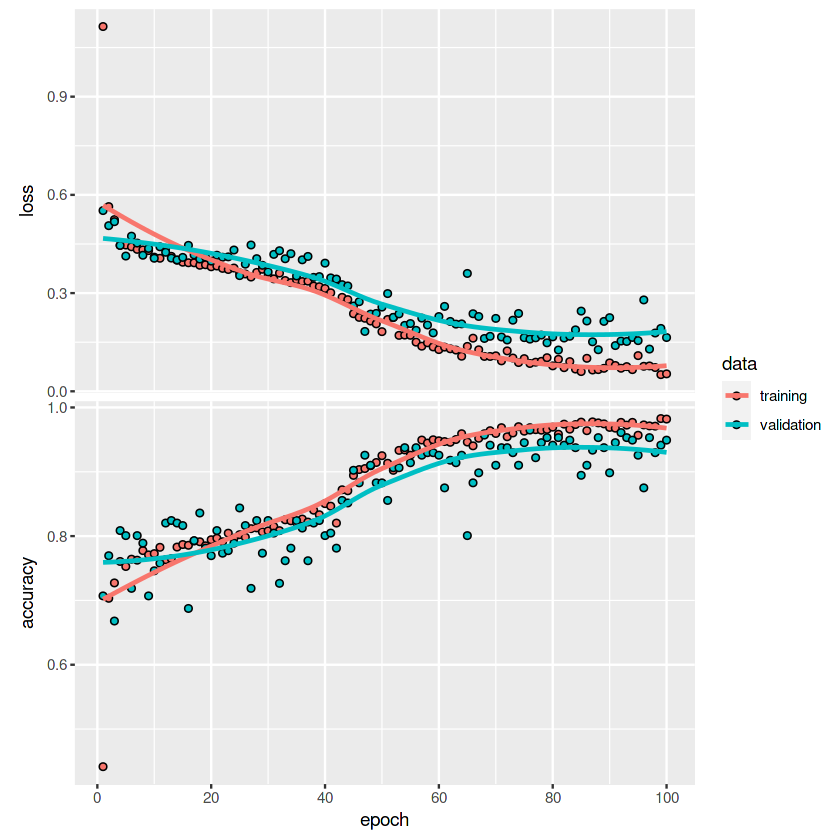

In [21]:
plot(hist)

`geom_smooth()` using formula 'y ~ x'



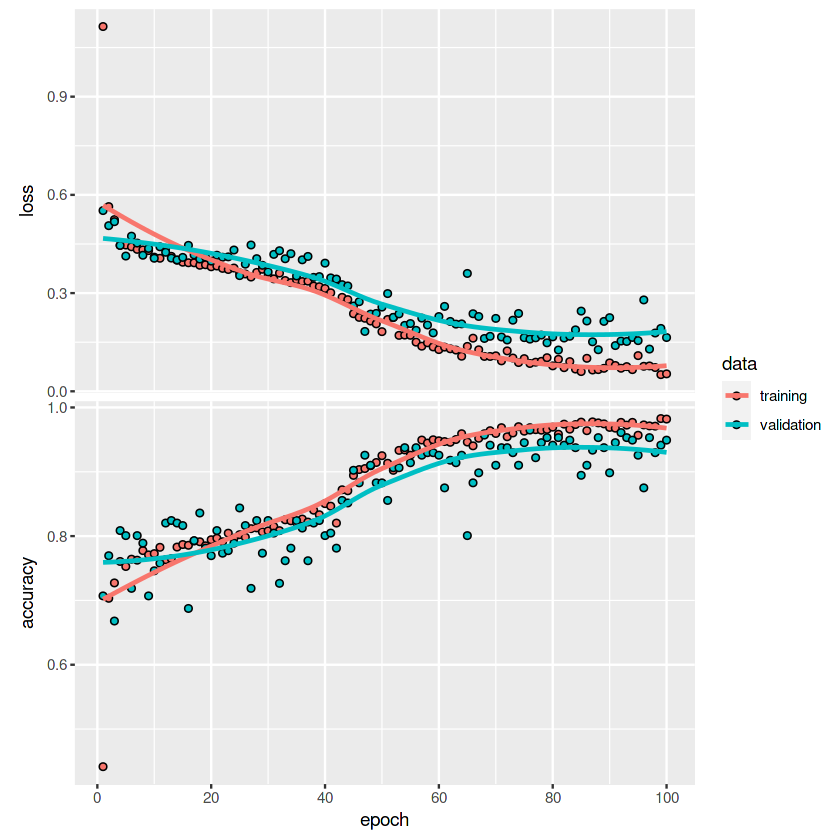

In [22]:
plot(hist)

In [23]:
model %>% save_model_hdf5("./my_model.h5")